In [1]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from rff.layers import GaussianEncoding #pip install random-fourier-features-pytorch
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
import os
import optuna
from optuna.trial import TrialState
from tab_transformer_pytorch import FTTransformer

c:\Users\prime\anaconda3\envs\DL\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Run regardless if you do or do not have GPU so all tensors are moved to right location later on
if torch.cuda.is_available():
    device_in_use = torch.device("cuda")
    print("GPU is available and being used")
else:
    device_in_use = torch.device("cpu")
    print("GPU is not available, using CPU instead")

GPU is not available, using CPU instead


# LOAD AND PROCESS DATA
**EXAMPLE WITH California Sklearn DATASET**

In [3]:
df_train = pd.read_csv('../../datasets/insurance/train.csv')
df_test = pd.read_csv('../../datasets/insurance/test.csv')
df_val = pd.read_csv('../../datasets/insurance/validation.csv')

In [4]:
def categorize_columns(dataframe, target):
    categorical_columns = []
    continuous_columns = []
    unique_classes_per_column = []  # To hold the number of unique classes for each categorical column

    for column in dataframe.columns:
        if dataframe[column].dtype == 'object' or len(dataframe[column].unique()) <= 10:
            # If the column's data type is 'object' or it has 10 or fewer unique values, consider it categorical.
            if column != target:
                categorical_columns.append(column)
                unique_classes_per_column.append(dataframe[column].nunique())  # Store the number of unique classes
        else:
            # Otherwise, consider it continuous.
            continuous_columns.append(column)

    return categorical_columns, continuous_columns, unique_classes_per_column

In [5]:
# there is a class that is not seen in the training data so the embedding fails on the test 
# I will recombine test and train to get the proper amount of classes (this may be a potential flaw in our model)
combined_df = pd.concat([df_train, df_test], ignore_index=True)
combined_df.shape


(8349, 86)

In [6]:
target = 'MOSTYPE'
cat_columns, cont_columns, unique_classes_per_column = categorize_columns(combined_df, target)

if target in cont_columns:
    cont_columns.remove(target)
elif target in cat_columns:
    print("in here")
    cat_columns.remove(target)

print("Target:", target)
print("Categorical: ", cat_columns)
print("Continous: ", cont_columns)
print("Unique Classes per Column: ", unique_classes_per_column)


#CHECKING TO MAKE SURE YOUR LIST IS CORRECT (NO NEED TO TOUCH)
yourlist = cat_columns + cont_columns + [target]
yourlist.sort()
oglist = list(df_train.columns)
oglist.sort()

assert(yourlist == oglist), "You may of spelled feature name wrong or you forgot to put on of them in the list"

le = LabelEncoder()
# label encode categorical features
for feature in cat_columns:
    df_train[feature] = le.fit_transform(df_train[feature])
    df_test[feature] = le.fit_transform(df_test[feature])
    df_val[feature] = le.fit_transform(df_val[feature])



target_classes = [max(len(df_train[target].value_counts()), len(df_val[target].value_counts()),len(df_test[target].value_counts()))]
print(target_classes)
# Create a StandardScaler and fit it to the cont features
scaler = StandardScaler()
scaler.fit(df_train[cont_columns]) if cont_columns else None

# Transform the training, test, and validation datasets
df_train[cont_columns] = scaler.transform(df_train[cont_columns]) if cont_columns else None
df_test[cont_columns] = scaler.transform(df_test[cont_columns]) if cont_columns else None
df_val[cont_columns] = scaler.transform(df_val[cont_columns]) if cont_columns else None 

class SingleTaskDataset(Dataset):
    def __init__(self, df : pd.DataFrame, cat_columns, num_columns,task1_column):
        self.n = df.shape[0]
        
        self.task1_labels = df[task1_column].astype(np.float32).values

        self.cate = df[cat_columns].astype(np.int64).values
        self.num = df[num_columns].astype(np.float32).values


    def __len__(self):
        return self.n
    
    def __getitem__(self, idx):
        # Retrieve features and labels from the dataframe using column names
        cat_features = self.cate[idx]
        num_features = self.num[idx]
        labels_task1 = self.task1_labels[idx]

        return cat_features, num_features, labels_task1

#Wrapping in Dataset
train_dataset = SingleTaskDataset(df_train, cat_columns, cont_columns, 'MOSTYPE')
val_dataset = SingleTaskDataset(df_val, cat_columns, cont_columns, 'MOSTYPE')
test_dataset = SingleTaskDataset(df_test, cat_columns, cont_columns, 'MOSTYPE')

#This is a hyperparameter that is not tuned. Maybe mess with what makes sense here
#Also try looking to see what other papers have done
batch_size = 256

# Wrapping with DataLoader for easy batch extraction
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

Target: MOSTYPE
Categorical:  ['MAANTHUI', 'MGEMOMV', 'MGEMLEEF', 'MOSHOOFD', 'MGODRK', 'MGODPR', 'MGODOV', 'MGODGE', 'MRELGE', 'MRELSA', 'MRELOV', 'MFALLEEN', 'MFGEKIND', 'MFWEKIND', 'MOPLHOOG', 'MOPLMIDD', 'MOPLLAAG', 'MBERHOOG', 'MBERZELF', 'MBERBOER', 'MBERMIDD', 'MBERARBG', 'MBERARBO', 'MSKA', 'MSKB1', 'MSKB2', 'MSKC', 'MSKD', 'MHHUUR', 'MHKOOP', 'MAUT1', 'MAUT2', 'MAUT0', 'MZFONDS', 'MZPART', 'MINKM30', 'MINK3045', 'MINK4575', 'MINK7512', 'MINK123M', 'MINKGEM', 'MKOOPKLA', 'PWAPART', 'PWABEDR', 'PWALAND', 'PPERSAUT', 'PBESAUT', 'PMOTSCO', 'PVRAAUT', 'PAANHANG', 'PTRACTOR', 'PWERKT', 'PBROM', 'PLEVEN', 'PPERSONG', 'PGEZONG', 'PWAOREG', 'PBRAND', 'PZEILPL', 'PPLEZIER', 'PFIETS', 'PINBOED', 'PBYSTAND', 'AWAPART', 'AWABEDR', 'AWALAND', 'APERSAUT', 'ABESAUT', 'AMOTSCO', 'AVRAAUT', 'AAANHANG', 'ATRACTOR', 'AWERKT', 'ABROM', 'ALEVEN', 'APERSONG', 'AGEZONG', 'AWAOREG', 'ABRAND', 'AZEILPL', 'APLEZIER', 'AFIETS', 'AINBOED', 'ABYSTAND', 'CARAVAN']
Continous:  []
Unique Classes per Column:  

In [7]:
# each task loss is scaled by its own learnable parameter, then regularization is applied 
class LossFunctions(nn.Module):
    def __init__(self, num_tasks):
        super(LossFunctions, self).__init__()
        self.num_tasks = num_tasks

        self.loss_fns = [nn.MSELoss() for x in range(num_tasks)] 

    def forward(self, predictions, labels_task1):

        #task 1
        target = labels_task1
        prediction = predictions
        loss_fn = self.loss_fns[0]
        task_loss = loss_fn(prediction, target)
        
        return task_loss
    
# Training and Testing Loops
def train(dataloader, model, loss_function, optimizer, device_in_use):
    model.train()

    total_loss = 0
    total_r2_score = 0
    root_mean_squared_error_total = 0

    for (categorical, numerical, labels_task1) in dataloader:
        categorical, numerical, labels_task1 = categorical.to(device_in_use), numerical.to(device_in_use), labels_task1.to(device_in_use)
        
        #running them through model and modifying the shape slightly for the loss function
        task_predictions = model(categorical, numerical)
        task_predictions = task_predictions.squeeze(1)
        
        loss = loss_function(task_predictions, labels_task1)
        total_loss += loss.item()
        
        # Calculate R^2 score for the regression task
        r2 = r2_score_manual(labels_task1, task_predictions)
        total_r2_score += r2

        # Calculate RMSE score for the regression task
        rmse_value = rmse(labels_task1, task_predictions)
        root_mean_squared_error_total+=rmse_value

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

    avg_loss = total_loss / len(dataloader)
    avg_r2_score = total_r2_score / len(dataloader)
    avg_rmse_score = root_mean_squared_error_total / len(dataloader)

    return avg_loss, avg_r2_score, avg_rmse_score

def test(dataloader, model, loss_function, device_in_use):
  model.eval()
  total_loss = 0
  
  total_loss = 0
  total_r2_score = 0
  root_mean_squared_error_total = 0

  with torch.no_grad():
    for (categorical, numerical, labels_task1) in dataloader:
        categorical, numerical, labels_task1 = categorical.to(device_in_use), numerical.to(device_in_use), labels_task1.to(device_in_use)

        task_predictions = model(categorical, numerical)
        task_predictions = task_predictions.squeeze(1)
        loss = loss_function(task_predictions, labels_task1)
        total_loss += loss.item()
        
        # Calculate R^2 score for the regression task
        r2 = r2_score_manual(labels_task1, task_predictions)
        total_r2_score += r2
        
        # Calculate RMSE score for the regression task
        rmse_value = rmse(labels_task1, task_predictions)
        root_mean_squared_error_total+=rmse_value

    avg_loss = total_loss / len(dataloader)
    avg_r2_score = total_r2_score / len(dataloader)
    avg_rmse_score = root_mean_squared_error_total / len(dataloader)

    return avg_loss, avg_r2_score, avg_rmse_score

def format_metric(value): # Used to format the metrics output
    return f"{value:.4f}"

def r2_score_manual(y_true, y_pred):
    # Calculate the mean of true labels
    y_mean = torch.mean(y_true)

    # Calculate the total sum of squares
    total_ss = torch.sum((y_true - y_mean)**2)

    # Calculate the residual sum of squares
    residual_ss = torch.sum((y_true - y_pred)**2)

    # Calculate R-squared
    r2 = 1 - (residual_ss / total_ss)

    return r2.item()  # Convert to a Python float

def rmse(y_true, y_pred):
    # Calculate the squared differences
    squared_diff = (y_true - y_pred)**2

    # Calculate the mean of the squared differences
    mean_squared_diff = torch.mean(squared_diff)

    # Calculate the square root to obtain RMSE
    rmse = torch.sqrt(mean_squared_diff)

    return rmse.item()  # Convert to a Python float

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

Number of parameters:  1746817
Epoch [ 1/100]       | Train: Loss 650.3610, R2 -2.9097, RMSE 25.4810                    | Test: Loss 580.9094, R2 -2.5260, RMSE 24.0848
Epoch [ 2/100]       | Train: Loss 573.2694, R2 -2.4518, RMSE 23.9318                    | Test: Loss 563.4321, R2 -2.4317, RMSE 23.7180
Epoch [ 3/100]       | Train: Loss 561.1708, R2 -2.3746, RMSE 23.6810                    | Test: Loss 549.7613, R2 -2.3140, RMSE 23.4442
Epoch [ 4/100]       | Train: Loss 551.8853, R2 -2.3164, RMSE 23.4871                    | Test: Loss 540.5361, R2 -2.2543, RMSE 23.2439
Epoch [ 5/100]       | Train: Loss 542.1708, R2 -2.2557, RMSE 23.2776                    | Test: Loss 531.7188, R2 -2.2093, RMSE 23.0564
Epoch [ 6/100]       | Train: Loss 532.9778, R2 -2.2086, RMSE 23.0793                    | Test: Loss 520.7151, R2 -2.1656, RMSE 22.8100
Epoch [ 7/100]       | Train: Loss 523.6356, R2 -2.1545, RMSE 22.8765                    | Test: Loss 514.9730, R2 -2.1222, RMSE 22.6878
Epoch [ 8/

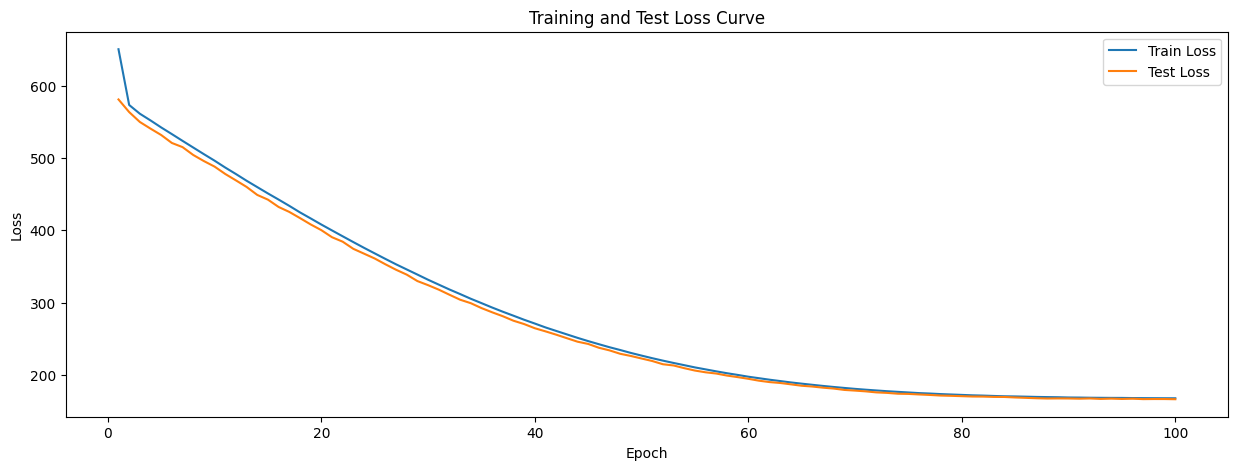

In [8]:
#Testing against the test dataset
model = FTTransformer(categories=tuple(unique_classes_per_column),
                          num_continuous=len(cont_columns),
                          dim=192,
                          depth=3,
                          heads=8,
                          dim_out=1,
                          attn_dropout=0.2,
                          ff_dropout=0.1).to(device_in_use)
loss_functions = LossFunctions(1)
optimizer = torch.optim.AdamW(params=model.parameters(), lr = 0.0001, weight_decay=0.00001)
epochs = 100 #Set the number of epochs

print("Number of parameters: ", count_parameters(model))

lowest_mse = float('inf')
train_losses = []
test_losses = []

for t in range(epochs):
  train_loss, r2_train, rmse_train = train(train_dataloader, model, loss_functions, optimizer, device_in_use=device_in_use)
  test_loss, r2_test, rmse_test = test(test_dataloader, model, loss_functions, device_in_use=device_in_use)
  
  # keep track of losses (MSE)
  train_losses.append(train_loss)
  test_losses.append(test_loss)


  if test_loss < lowest_mse:
    lowest_mse = test_loss

  epoch_str = f"Epoch [{t+1:2}/{epochs}]"
  train_metrics = f"Train: Loss {format_metric(train_loss)}, R2 {format_metric(r2_train)}, RMSE {format_metric(rmse_train)}"
  test_metrics = f"Test: Loss {format_metric(test_loss)}, R2 {format_metric(r2_test)}, RMSE {format_metric(rmse_test)}"
  print(f"{epoch_str:20} | {train_metrics:65} | {test_metrics}")


torch.save(model.state_dict(), 'tab_model_trained.pth')

# Plotting the loss curves
plt.figure(figsize=(15, 5))
plt.subplot(1, 1, 1)
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, epochs+1), [l for l in test_losses], label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Test Loss Curve')
plt.legend()

print("Lowest MSE: ", lowest_mse)

